# Shadow attack

### Training a DecisionTree and testing a shadow Attack

In this test we build a target classifier and an attacker model, then we evaluate the privacy risks using Liwei Song privacy score metrics. 

#### Workflow:
    - Download data
    - Split tha data into subsets
    - Train a machine classifier model with the first subset
    - Train the shadow models with the rest of the subsets
    - Use the probability predicted from the shadow model to train an attacker model
    - Use the atatcker model on the probabilities predicted from the target model

## part 1  - Preparing the data
- prepare dataset
    - download dataset
    - observe the dataset quality
    - shuffle dataset
    - split into subsets

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from membership_inference_attacks import black_box_benchmarks
from privacy_risk_score_utils import calculate_risk_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing
from sklearn import utils

plt.style.use('ggplot')

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
random_state = 20
np.random.seed(random_state)

In [2]:
dataset_type = 2

if (dataset_type == 0):
    data_url = "winequality-red.csv"
    target_name = 'quality'

    df = pd.read_csv(data_url, sep = ';', header = 0)
elif (dataset_type == 1):
    target_name = "class"
    dataset = datasets.fetch_covtype()
    df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
    df[target_name] = dataset.target
elif (dataset_type == 2):
    target_name = "class"
    dataset = datasets.fetch_openml(name='gas-drift-different-concentrations')
    df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
    df[target_name] = dataset.target
    lab_enc = preprocessing.LabelEncoder()
    encoded = lab_enc.fit_transform(df[target_name])
    df[target_name] = encoded

n_features = len(pd.unique(df[target_name]))
features = pd.unique(df[target_name])
features.sort()
print("There are "+ str(n_features) + " unique labels: ")  
print(features)

min_feature = features[0] #lower numeric feature
max_feature = features[n_features-1] #highest numeric feature

test_size_model = 0.5
test_size_shadow = 0.5

df.head()

There are 6 unique labels: 
[0 1 2 3 4 5]


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V121,V122,V123,V124,V125,V126,V127,V128,V129,class
0,12285.6582,4.076635,4.842317,7.509393,10.822436,-1.312657,-1.853717,-6.924985,11800.9233,4.483500,...,1784.5324,1.907000,1.729200,4.881194,8.623828,-0.314110,-0.661556,-3.521663,10.0,3
1,-35.6889,0.993944,0.166099,0.489363,3.484663,-0.130298,-0.528364,-3.735347,266.4145,1.053988,...,904.9898,1.433707,1.068069,2.532958,5.369720,-0.183779,-0.534087,-4.635975,50.0,2
2,63927.2217,14.956941,19.971376,29.188512,33.291320,-10.433776,-16.062245,-49.490143,57405.8483,15.613843,...,14585.7879,8.189021,6.099452,12.127991,15.709651,-3.887082,-6.731473,-19.326895,250.0,3
3,2992.9019,1.380553,0.808910,1.288259,4.660135,-0.755903,-1.120470,-4.075213,4301.4033,1.652701,...,6044.5554,3.488295,2.662288,5.938297,8.544508,-1.567322,-2.701235,-6.472439,600.0,2
4,57524.7812,11.912566,14.631496,19.809240,23.715868,-9.084750,-11.770585,-39.234003,50051.0703,11.732548,...,10580.1006,5.752675,3.880740,8.545897,11.831716,-2.655521,-4.312744,-8.510591,150.0,3


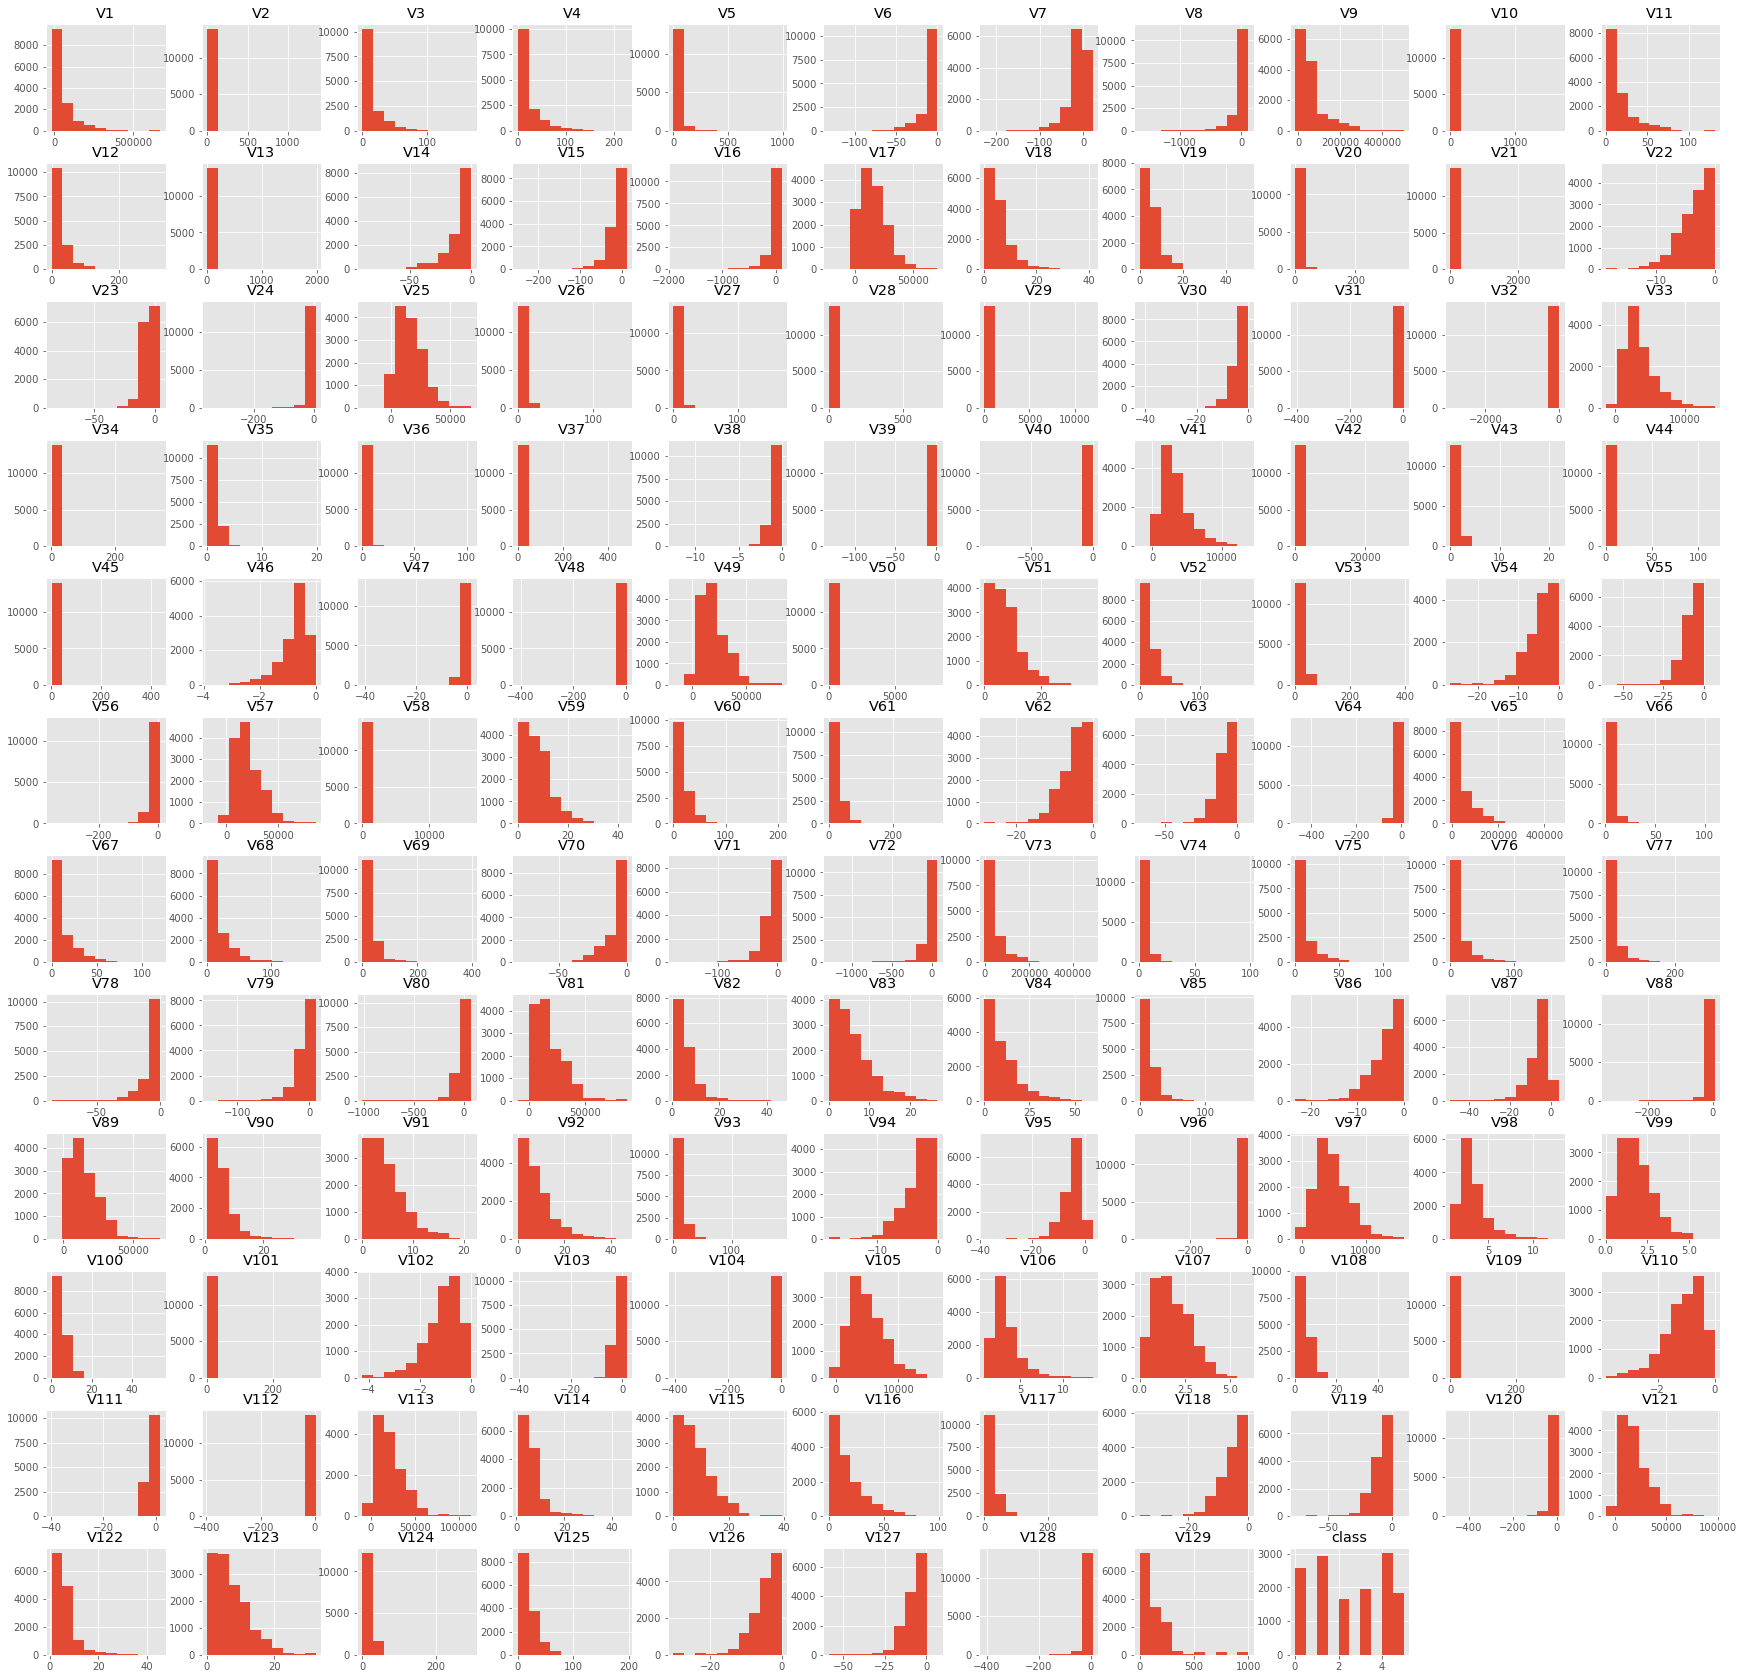

In [3]:
pd.DataFrame.hist(df
                  , figsize = [30,30]
                 );

In [4]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V121,V122,V123,V124,V125,V126,V127,V128,V129,class
count,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,...,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000
mean,50435.066174,6.638156,12.936688,18.743953,26.890695,-9.158655,-14.402383,-59.927598,57340.104585,6.648033,...,19688.565373,6.072066,7.138634,14.929364,19.090980,-4.901016,-8.167792,-16.089791,157.094644,2.387994
std,69844.785952,13.486391,17.610061,24.899450,38.107685,12.729206,21.304606,131.017675,64045.265134,15.585780,...,14281.652395,4.642192,5.248573,12.437311,14.391810,4.195360,7.637701,20.958479,171.443975,1.728602
min,-16757.598600,0.088287,0.000100,0.000100,0.000100,-131.332873,-227.627758,-1664.735576,-16119.460900,0.185164,...,-8297.548800,0.712112,0.003238,0.011488,0.118849,-30.205911,-58.844076,-410.152297,1.000000,0.000000
25%,6694.725950,2.284843,1.633350,2.386836,4.967988,-11.587169,-17.292559,-48.492764,13287.301875,2.776693,...,8837.838750,3.007381,3.059178,5.407551,8.039227,-6.789599,-11.162406,-18.938690,50.000000,1.000000
50%,19364.439350,3.871227,4.977123,7.250892,11.680725,-3.338700,-4.956917,-14.040088,37764.263200,4.734586,...,16313.967300,4.973783,5.809107,11.325214,14.560676,-3.881763,-6.305962,-11.747499,100.000000,2.000000
75%,63104.837125,8.400619,17.189166,26.411109,34.843226,-1.126897,-1.670327,-5.212213,70300.782575,8.608522,...,27009.592425,7.389566,10.222169,21.207572,26.547437,-1.804032,-2.874532,-6.429690,200.000000,4.000000
max,670687.347700,1339.879283,167.079751,226.619457,993.605306,-0.006941,22.201589,115.273147,502202.812500,1672.363221,...,96706.792700,45.574835,32.203601,297.225880,195.242555,-0.003817,6.851792,8.357968,1000.000000,5.000000


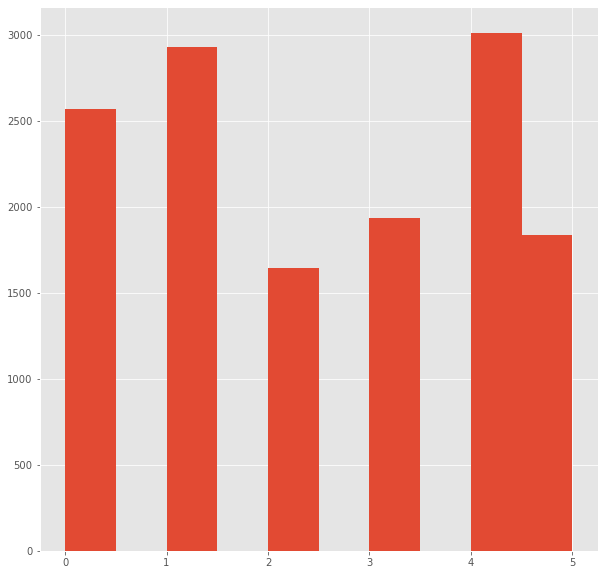

In [5]:
plt.hist(df[target_name])
plt.show()

In [6]:
# split dataset in n_datasets

n_rows = df.shape[0] # number of elements in the datasets
n_datasets = 10 #number of sub-datatsets to divide the datatsets

n_elements = math.floor(n_rows/n_datasets)

#shuffle the dataset
df = df.sample(frac=1, random_state = random_state).reset_index(drop=True)

dfList = []
for i in range(0, n_rows, n_elements):
    dfList.append(df[i:i+n_elements])

# print the labels on each dataset to make sure that in every subsets there is at least one example for each class
for i in range(n_datasets):
    temp = pd.unique(dfList[i][target_name])
    temp.sort()
    print("" + str(i) + ": [" + ", ".join(map(str, temp)) + "]")

0: [0, 1, 2, 3, 4, 5]
1: [0, 1, 2, 3, 4, 5]
2: [0, 1, 2, 3, 4, 5]
3: [0, 1, 2, 3, 4, 5]
4: [0, 1, 2, 3, 4, 5]
5: [0, 1, 2, 3, 4, 5]
6: [0, 1, 2, 3, 4, 5]
7: [0, 1, 2, 3, 4, 5]
8: [0, 1, 2, 3, 4, 5]
9: [0, 1, 2, 3, 4, 5]


## part 2 - Target model
- train the target model
    - split first dataset into training and testing    
    - train model
    - compute test and training accuracy
    - prepare the data for the MIA evaluation (probabilities + label)

In [7]:
df = dfList[0]
X = df.drop([target_name], axis = 1) # drop the class column
y = df[target_name] # Class only

print(X.shape, y.shape)

(1391, 129) (1391,)


In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = test_size_model, random_state = random_state)  

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
print('There are', Xtrain.shape[0], 'samples in the training dataset')
print('There are', Xtest.shape[0], 'samples in the testing dataset')
print('Each sample has', len(Xtrain.columns), 'features')

(695, 129) (696, 129) (695,) (696,)
There are 695 samples in the training dataset
There are 696 samples in the testing dataset
Each sample has 129 features


In [9]:
model = DecisionTreeClassifier(criterion="entropy", min_samples_leaf=30, max_depth=15, random_state=random_state)
model.fit(X = Xtrain, y = ytrain)
ytrain_model = model.predict(Xtrain)

target_train_accurancy = accuracy_score(ytrain, ytrain_model)*100

print('The accuracy on training set is', target_train_accurancy, '%')

ytest_model = model.predict(Xtest)

target_test_accurancy = accuracy_score(ytest, ytest_model)*100

print('The accuracy on testing set is', target_test_accurancy, '%\n')

fitted_max_depth = model.tree_.max_depth
print('The maximum depth of the tree fitted on X_train is', fitted_max_depth)

print("")

yprob_model_train = model.predict_proba(Xtrain)
yprob_model_test = model.predict_proba(Xtest)

print(yprob_model_train)

The accuracy on training set is 80.43165467625899 %
The accuracy on testing set is 73.70689655172413 %

The maximum depth of the tree fitted on X_train is 8

[[0.12121212 0.33333333 0.03030303 0.12121212 0.         0.39393939]
 [0.         0.06666667 0.         0.86666667 0.         0.06666667]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.03389831 0.         0.94915254 0.01694915 0.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]
 [0.04651163 0.         0.         0.         0.86046512 0.09302326]]


In [10]:
#function to prepare the porbabilities and labels to be stored in couples
def prepare_for_MIA(yprob_train_model,labels):
    
    return_outputs, return_labels = [], []
    min_labels = pd.unique(labels)
    min_labels.sort()
    min_label = min_labels[0]
    # -min_label becasue in the MIA evaluation consider the positions of the label from 0...n_labels (here they start at 1)
    for (yprob, label) in zip(yprob_train_model, labels):
            return_labels.append(np.array([label-min_label])) #without np.array([]) it would give the error cannot contenate 0d dimension array
            return_outputs.append(yprob)
    return_labels = np.concatenate(return_labels)
    return (return_outputs, return_labels)


target_train_probabilities = model.predict_proba(Xtrain)
target_test_probabilities = model.predict_proba(Xtest)

target_train_performance = []
target_test_performance = []
        
target_train_performance = prepare_for_MIA(target_train_probabilities, ytrain)
target_test_performance = prepare_for_MIA(target_test_probabilities, ytest)

In [11]:
miss_target_train_probabilities = target_train_probabilities[ytrain != ytrain_model]
miss_target_test_probabilities = target_test_probabilities[ytest != ytest_model]
miss_ytrain = ytrain[ytrain != ytrain_model]
miss_ytest = ytest[ytest != ytest_model]

miss_target_train_performance = []
miss_target_test_performance = []
        
miss_target_train_performance = prepare_for_MIA(miss_target_train_probabilities, miss_ytrain)
miss_target_test_performance = prepare_for_MIA(miss_target_test_probabilities, miss_ytest)

class_target_train_probabilities = target_train_probabilities[ytrain == ytrain_model]
class_target_test_probabilities = target_test_probabilities[ytest == ytest_model]
class_ytrain = ytrain[ytrain == ytrain_model]
class_ytest = ytest[ytest == ytest_model]

class_target_train_performance = []
class_target_test_performance = []
        
class_target_train_performance = prepare_for_MIA(class_target_train_probabilities, class_ytrain)
class_target_test_performance = prepare_for_MIA(class_target_test_probabilities, class_ytest)

## part 3
- train shadow models
    - train 3 shadow models on the sub-databases
    - use the tests dataset as example not use for training
    - create a dataset with guess probabiities and if is part of the dataset yes or no
    - try with and without pruning of the tree
    - try adding the data row next to the guesses

In [12]:
models = []

X_shadow = []
y_shadow = []

X_shadow_train = []
X_shadow_test = []
y_shadow_train = []
y_shadow_test = []

yprob_train_model = []
yprob_test_model = []

y_shadow_train_model = []
y_shadow_test_model = []

for i in range(n_datasets-1):
    
    X_shadow.append(dfList[i+1].drop([target_name], axis = 1)) # drop the class column
    y_shadow.append(dfList[i+1][target_name]) # Class only
    print(i)
    X_shadow_train_temp, X_shadow_test_temp, y_shadow_train_temp, y_shadow_test_temp = train_test_split(X_shadow[i], y_shadow[i], test_size = test_size_shadow, random_state = random_state)
    
    
    X_shadow_train.append(X_shadow_train_temp)
    X_shadow_test.append(X_shadow_test_temp)
    y_shadow_train.append(y_shadow_train_temp)
    y_shadow_test.append(y_shadow_test_temp)
    

    models.append(DecisionTreeClassifier(criterion="entropy", min_samples_leaf=30, max_depth=20))
    models[i].fit(X = X_shadow_train[i], y = y_shadow_train[i])
    
    y_shadow_train_model.append(models[i].predict(X_shadow_train[i]))
    
    accurancy = accuracy_score(y_shadow_train[i], y_shadow_train_model[i])*100

    print('The accuracy on training set', i,' is', accurancy, '%')

    y_shadow_test_model.append(models[i].predict(X_shadow_test[i]))

    accurancy = accuracy_score(y_shadow_test[i], y_shadow_test_model[i])*100

    print('The accuracy on testing set', i,' is', accurancy, '%')

    fitted_max_depth = models[i].tree_.max_depth
    print('The maximum depth of the tree', i,' fitted on X_shadow_train is', fitted_max_depth)
    
    yprob_train_model.append(models[i].predict_proba(X_shadow_train[i]))
    yprob_test_model.append(models[i].predict_proba(X_shadow_test[i]))

0
The accuracy on training set 0  is 76.54676258992805 %
The accuracy on testing set 0  is 70.25862068965517 %
The maximum depth of the tree 0  fitted on X_shadow_train is 6
1
The accuracy on training set 1  is 80.43165467625899 %
The accuracy on testing set 1  is 73.13218390804597 %
The maximum depth of the tree 1  fitted on X_shadow_train is 7
2
The accuracy on training set 2  is 81.72661870503597 %
The accuracy on testing set 2  is 75.14367816091954 %
The maximum depth of the tree 2  fitted on X_shadow_train is 7
3
The accuracy on training set 3  is 78.70503597122303 %
The accuracy on testing set 3  is 71.98275862068965 %
The maximum depth of the tree 3  fitted on X_shadow_train is 6
4
The accuracy on training set 4  is 81.72661870503597 %
The accuracy on testing set 4  is 77.29885057471265 %
The maximum depth of the tree 4  fitted on X_shadow_train is 7
5
The accuracy on training set 5  is 78.56115107913669 %
The accuracy on testing set 5  is 73.70689655172413 %
The maximum depth o

In [13]:
#probability obtained by the shadow model on the train and test data, for the MIA evaluation

shadow_train_performance = []
shadow_test_performance = []

temp_shadow_train_performance = []
temp_shadow_test_performance = []
 
temp_prob = []
temp_tran = []

for i in range(n_datasets-1):
    for v in yprob_train_model[i]:
        temp_prob.append(v)
    for v in y_shadow_train[i]:
        temp_tran.append(v)
        
shadow_train_performance = prepare_for_MIA(temp_prob, temp_tran)

temp_prob = []
temp_tran = []

for i in range(n_datasets-1):
    for v in yprob_test_model[i]:
        temp_prob.append(v)
    for v in y_shadow_test[i]:
        temp_tran.append(v)
        
shadow_test_performance= prepare_for_MIA(temp_prob, temp_tran)

In [14]:
#probabilities that the target model obtain on the data used of the shadow classifier, for the MIA evaluation

target_shadow_train_performance = []
target_shadow_test_performance = []

y_target_on_shadow_train = []
targ_prob = []
temp_tran = []
      
for i in range(n_datasets-1):
    y_target_on_shadow_train.append(model.predict_proba(X_shadow_train[i]))

for i in range(n_datasets-1):
    for v in y_target_on_shadow_train[i]:
        targ_prob.append(v)
    for v in y_shadow_train[i]:
        temp_tran.append(v)

target_shadow_train_performance = prepare_for_MIA(targ_prob, temp_tran)
                                    
y_target_on_shadow_test = []                                 
targ_prob = []
temp_tran = []

for i in range(n_datasets-1):
    y_target_on_shadow_test.append(model.predict_proba(X_shadow_test[i]))
                                    
for i in range(n_datasets-1):
    for v in y_target_on_shadow_test[i]:
        targ_prob.append(v)
    for v in y_shadow_test[i]:
        temp_tran.append(v)
        
target_shadow_test_performance = prepare_for_MIA(targ_prob, temp_tran)

In [15]:
#preparing MIA evaluation for the case with only misclassified examples

miss_target_shadow_train_performance = []
miss_target_shadow_test_performance = []

miss_y_shadow_train = []
miss_y_shadow_test = []

miss_y_target_on_shadow_train = []
temp_y_target_on_shadow_train = []
targ_prob = []
temp_tran = []
      
for i in range(n_datasets-1):
    temp_y_target_on_shadow_train.append(model.predict_proba(X_shadow_train[i]))

for i in range(n_datasets-1):
    miss_y_target_on_shadow_train.append(temp_y_target_on_shadow_train[i][y_shadow_train[i] != y_shadow_train_model[i]])
    miss_y_shadow_train.append(y_shadow_train[i][y_shadow_train[i] != y_shadow_train_model[i]])
    
for i in range(n_datasets-1):
    for v in miss_y_target_on_shadow_train[i]:
        targ_prob.append(v)
    for v in miss_y_shadow_train[i]:
        temp_tran.append(v)
        
miss_shadow_train_performance = prepare_for_MIA(targ_prob, temp_tran)
                                    
temp_y_target_on_shadow_test = []      
miss_y_target_on_shadow_test = []
targ_prob = []
temp_tran = []

for i in range(n_datasets-1):
    temp_y_target_on_shadow_test.append(model.predict_proba(X_shadow_test[i]))
         
for i in range(n_datasets-1):
    miss_y_target_on_shadow_test.append(temp_y_target_on_shadow_test[i][y_shadow_test[i] != y_shadow_test_model[i]])
    miss_y_shadow_test.append(y_shadow_test[i][y_shadow_test[i] != y_shadow_test_model[i]])
        
for i in range(n_datasets-1):
    for v in miss_y_target_on_shadow_test[i]:
        targ_prob.append(v)
    for v in miss_y_shadow_test[i]:
        temp_tran.append(v)
        
miss_shadow_test_performance = prepare_for_MIA(targ_prob, temp_tran)

In [16]:
#create dataframe with yprob_train_model and a column with 'yes'; yprob_test_model and a column with 'no'
#shouffle it, split it in train and  and feed to the attacker
#perform the attack (predict over a dataset made from the original decision tree)

guesses = []
truth_labels = []
training = []

for i in range(n_datasets-1):
    for j in yprob_train_model[i]: #to concatenate the lists
        guesses.append(j)
    #for j in y_shadow_train[i]: #to concatenate the lists
    #    truth_labels.append(j)
    for j in y_shadow_train_model[i]: #to concatenate the lists
        truth_labels.append(j)
    
n_yes = len(guesses) # 1197 (num. elements in the dabase used for training [399*3]) - 300 (num. elements used in the testing [100*3]) = 897
    
for i in range(n_datasets-1):
    for j in yprob_test_model[i]:
        guesses.append(j)
    #for j in y_shadow_test[i]: #to concatenate the lists
    #    truth_labels.append(j)
    for j in y_shadow_test_model[i]: #to concatenate the lists
        truth_labels.append(j)
        
n_no = len(guesses) - n_yes # number of elements that are in the test section
    
print("Number of elements that were used for training " + str(n_yes))
print("Number of elments that were used for testing " + str(n_no))
    
training_yes = ['yes'] * n_yes
training_no = ['no'] * n_no
training = training_yes + training_no

df_shadow = pd.DataFrame({'guesses': guesses})
df_shadow['labels'] = truth_labels
df_shadow['training'] = training

print(df_shadow)

Number of elements that were used for training 6255
Number of elments that were used for testing 6264
                                                 guesses  labels training
0      [0.9666666666666667, 0.03333333333333333, 0.0,...       0      yes
1                         [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]       1      yes
2                       [0.0, 0.54, 0.46, 0.0, 0.0, 0.0]       1      yes
3                         [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]       0      yes
4                   [0.0, 0.0, 0.0, 0.0, 0.9375, 0.0625]       4      yes
...                                                  ...     ...      ...
12514  [0.29411764705882354, 0.0, 0.08823529411764706...       3       no
12515  [0.0, 0.0, 0.0, 0.16666666666666666, 0.8333333...       4       no
12516  [0.0, 0.0, 0.0, 0.0, 0.9491525423728814, 0.050...       4       no
12517                     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]       0       no
12518  [0.16666666666666666, 0.16666666666666666, 0.0...       4       no

[12519 ro

In [17]:
#shouffle dataset

df_shadow = df_shadow.sample(frac=1).reset_index(drop=True)

columns = range(min_feature,min_feature+n_features,1)

df_shadow_t = pd.DataFrame(df_shadow['guesses'].to_list(), columns=columns)
df_shadow_t['training'] = df_shadow['training']
df_shadow_t['labels'] = df_shadow['labels']

df_shadow = df_shadow_t

df_shadow = df_shadow.fillna(0.0)
print(df_shadow)

              0         1         2         3         4         5 training  \
0      0.033333  0.000000  0.033333  0.200000  0.733333  0.000000      yes   
1      0.000000  0.021277  0.000000  0.042553  0.319149  0.617021       no   
2      0.045455  0.522727  0.000000  0.090909  0.000000  0.340909      yes   
3      0.066667  0.022222  0.000000  0.022222  0.600000  0.288889       no   
4      0.000000  0.000000  0.000000  0.000000  0.000000  1.000000       no   
...         ...       ...       ...       ...       ...       ...      ...   
12514  0.000000  0.021277  0.000000  0.042553  0.319149  0.617021       no   
12515  0.188679  0.622642  0.056604  0.037736  0.094340  0.000000       no   
12516  0.016949  0.067797  0.915254  0.000000  0.000000  0.000000      yes   
12517  0.500000  0.000000  0.093750  0.343750  0.062500  0.000000      yes   
12518  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000      yes   

       labels  
0           4  
1           5  
2           1  

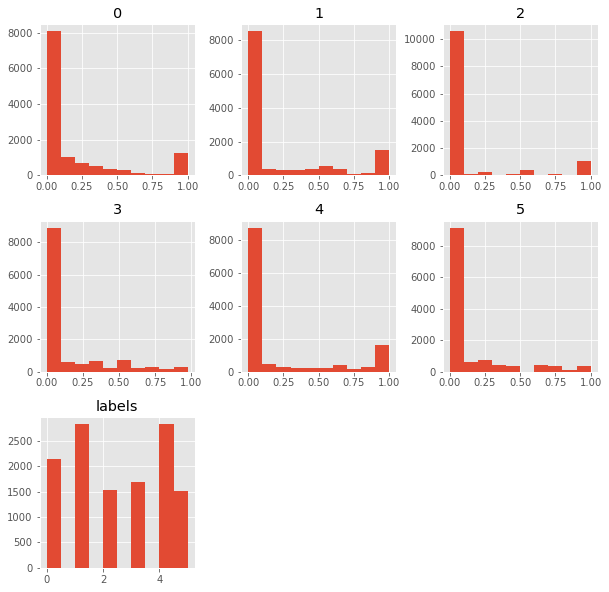

In [18]:
pd.DataFrame.hist(df_shadow
                  , figsize = [10,10]
                 );

In [19]:
df_shadow.describe()

,0,1,2,3,4,5,labels
count,12519.000000,12519.000000,12519.000000,12519.000000,12519.000000,12519.000000,12519.000000
mean,0.185470,0.211127,0.118032,0.138880,0.213575,0.132917,2.382618
std,0.311100,0.342302,0.278142,0.239685,0.357208,0.249857,1.699959
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,0.215686,0.368421,0.033333,0.166667,0.270833,0.121212,4.000000
max,1.000000,1.000000,1.000000,0.975000,1.000000,1.000000,5.000000


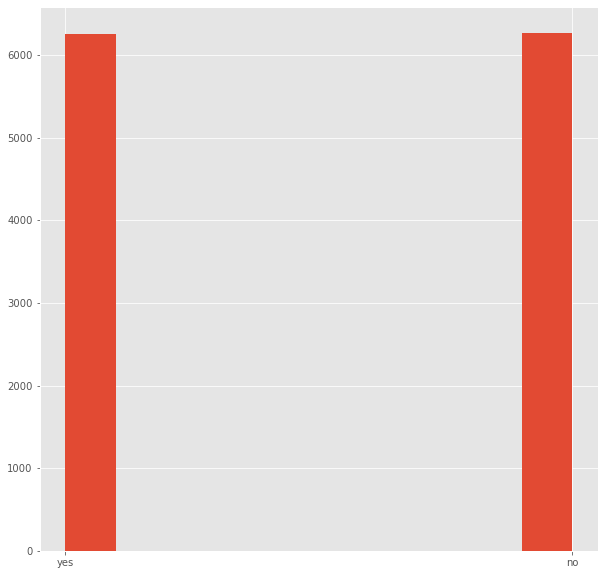

In [20]:
plt.hist(df_shadow['training'])
plt.show()

## part 4 - train the attack classifier
- train shadow attacker

In [21]:
attacker_target_name = 'training'

X_attacker = df_shadow.drop([attacker_target_name], axis = 1) # drop the class column
y_attacker = df_shadow[attacker_target_name] # Class only

print(X_attacker.shape)
print(y_attacker.shape)

(12519, 7)
(12519,)


In [22]:
Xtrain_attacker, Xtest_attacker, ytrain_attacker, ytest_attacker = train_test_split(X_attacker,y_attacker, random_state = random_state)  

print(Xtrain_attacker.shape, Xtest_attacker.shape, ytrain_attacker.shape, ytest_attacker.shape)
print('There are', Xtrain_attacker.shape[0], 'samples in the training dataset')
print('There are', Xtest_attacker.shape[0], 'samples in the testing dataset')
print('Each sample has', len(Xtrain_attacker.columns), 'features')

(9389, 7) (3130, 7) (9389,) (3130,)
There are 9389 samples in the training dataset
There are 3130 samples in the testing dataset
Each sample has 7 features


In [23]:
model_attacker = DecisionTreeClassifier(criterion="entropy", min_samples_leaf=40, max_depth=20)
model_attacker.fit(X = Xtrain_attacker, y = ytrain_attacker)
ytrain_model_attacker = model_attacker.predict(Xtrain_attacker)

shadow_train_accurancy = accuracy_score(ytrain_attacker, ytrain_model_attacker)*100

print('The accuracy on training set is', shadow_train_accurancy, '%')

ytest_model_attacker = model_attacker.predict(Xtest_attacker)

shadow_test_accurancy = accuracy_score(ytest_attacker, ytest_model_attacker)*100

print('The accuracy on testing set is',shadow_test_accurancy, '%')

fitted_max_depth = model_attacker.tree_.max_depth
print('The maximum depth of the tree fitted on X_train is', fitted_max_depth)

print(confusion_matrix(y_true = ytest_attacker, y_pred = ytest_model_attacker))
print(classification_report(ytest_attacker, ytest_model_attacker))

The accuracy on training set is 54.12717009266162 %
The accuracy on testing set is 50.159744408945684 %
The maximum depth of the tree fitted on X_train is 20
[[727 829]
 [731 843]]
              precision    recall  f1-score   support

          no       0.50      0.47      0.48      1556
         yes       0.50      0.54      0.52      1574

    accuracy                           0.50      3130
   macro avg       0.50      0.50      0.50      3130
weighted avg       0.50      0.50      0.50      3130



In [24]:
#using gridSearchCV to improve the model

# Set the parameters to be explored by the grid for each classifier
tuned_param_svc = [{'kernel': ['rbf'], 
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100, 1000],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100, 1000],                     
                    },
                   ]
tuned_param_knn = [{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]
tuned_param_lr = [{ 'solver': 'liblinear',
                    'penalty': ['l1', 'l2']
                    },
                  ]

# set the models to be fitted specifying name, estimator and parameter structure
models = {
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(), 
           'param': tuned_param_svc
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn
        
          },
    'lr': {
            'name': 'Logistic Regression ',
            'estimator': LogisticRegression(),
            'param': tuned_param_lr
          },
}

# scores to be explored
scores = [
         # 'precision_micro', 
         # 'recall_micro',
          #'f1_micro',
          'accuracy'
         ]

def print_result(model):
    i = 0
    for param in model.cv_results_['params']:
        print("{:.3f} (+/- {:.3f}) for {}".format(model.cv_results_['mean_test_score'][i], 2*model.cv_results_['std_test_score'][i], param))
        i = i + 1

In [25]:
# result_dict = {}

# for model in models:
#      print('|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||')
#      print(models[model]['name'],'\n')
#      for score in scores:
#          print('====================================================================================')
#          print(score)
#          print('====================================================================================\n')
        
#          results = GridSearchCV(models[model]['estimator'], param_grid=models[model]['param'], scoring=score)
#          results.fit(Xtrain_attacker, ytrain_attacker)
        
#          print('Best param:', results.best_params_, '\n')
        
#          result_dict["{}:{}".format(models[model]['name'], score)] = round(results.best_score_, 3)
        
#          print_result(results)
#          print('\n')
#          print(classification_report(y_true = ytest_attacker, y_pred = results.predict(Xtest_attacker)))

In [26]:
#result_dict()

## part 5 - performing the custom attack
- attack the trained model

In [27]:
#shouffle dataset
#test using label in the training of the attacker

guesses_defender = []
labels_defender = [] #truth labels from the dataset
training_defender = []
predicted_labels = [] #labels as the model predicted them

#remember: yprob_model_train is the probability predicted by the target model on Xtrain

for j in yprob_model_train: #to concatenate the lists
    guesses_defender.append(j)
for j in ytrain:
    labels_defender.append(j)
for j in ytrain_model:
    predicted_labels.append(j)
    
training_yes = len(guesses_defender)
    
for j in yprob_model_test:
    guesses_defender.append(j)
for j in ytest:
    labels_defender.append(j)
for j in ytest_model:
    predicted_labels.append(j)

training_no = len(guesses_defender) - training_yes
    
training_yes = ['yes'] * training_yes
training_no = ['no'] * training_no
training_defender = training_yes + training_no

df_defender = pd.DataFrame({'guesses': guesses_defender})
df_defender['training'] = training_defender
df_defender['labels'] = labels_defender
df_defender['predicted labels'] = predicted_labels

df_defender = df_defender.sample(frac=1).reset_index(drop=True)

df_predicted_label = df_defender['predicted labels']

classes = df_defender['labels'] #classes that each row of de df_defender classifier originally belongs to

columns = range(min_feature,min_feature+n_features,1)

df_defender_t = pd.DataFrame(df_defender['guesses'].to_list(), columns=columns)
df_defender_t['training'] = df_defender['training']
#df_defender_t['labels'] = df_defender['labels']
df_defender_t['labels'] = df_defender['predicted labels']

df_defender = df_defender_t

df_defender.head()

,0,1,2,3,4,5,training,labels
0,0.275000,0.0,0.0,0.525000,0.200000,0.000000,yes,3
1,0.032258,0.0,0.0,0.516129,0.000000,0.451613,yes,3
2,0.000000,0.0,0.0,0.000000,0.083333,0.916667,no,5
3,0.046512,0.0,0.0,0.000000,0.860465,0.093023,no,4
4,1.000000,0.0,0.0,0.000000,0.000000,0.000000,no,0


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'labels'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

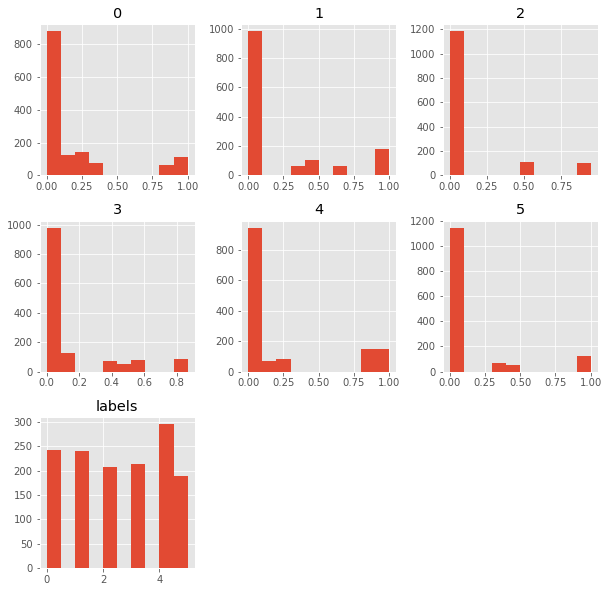

In [28]:
pd.DataFrame.hist(df_defender
                  , figsize = [10,10]
                 )

In [29]:
X_attack = df_defender.drop([attacker_target_name], axis = 1) # drop the training column
y_attack = df_defender[attacker_target_name] # Class only

y_model_attack = model_attacker.predict(X_attack)

r_attack_accurancy = accuracy_score(y_attack, y_model_attack)*100

print('The accuracy on the attack is', r_attack_accurancy, '%')

print(confusion_matrix(y_true = y_attack, y_pred = y_model_attack))
print(classification_report(y_attack, y_model_attack))

The accuracy on the attack is 48.31056793673616 %
[[285 411]
 [308 387]]
              precision    recall  f1-score   support

          no       0.48      0.41      0.44       696
         yes       0.48      0.56      0.52       695

    accuracy                           0.48      1391
   macro avg       0.48      0.48      0.48      1391
weighted avg       0.48      0.48      0.48      1391



In [30]:
y_model_attack_missclassified = y_model_attack[classes != df_predicted_label]

y_attack_missclassified = y_attack[classes != df_predicted_label]

print(len(y_attack_missclassified))
print(len(y_model_attack_missclassified))

attack_accurancy = accuracy_score(y_attack_missclassified, y_model_attack_missclassified)*100

print('The accuracy on the attack is', attack_accurancy, '%')

print(confusion_matrix(y_true = y_attack_missclassified, y_pred = y_model_attack_missclassified))
print(classification_report(y_attack_missclassified, y_model_attack_missclassified))


y_model_attack_classified = y_model_attack[classes == df_predicted_label]

y_attack_classified = y_attack[classes == df_predicted_label]

print(len(y_attack_classified))
print(len(y_model_attack_classified))

attack_accurancy = accuracy_score(y_attack_classified, y_model_attack_classified)*100

print('The accuracy on the attack is', attack_accurancy, '%')

print(confusion_matrix(y_true = y_attack_classified, y_pred = y_model_attack_classified))
print(classification_report(y_attack_classified, y_model_attack_classified))

319
319
The accuracy on the attack is 45.141065830721004 %
[[91 92]
 [83 53]]
              precision    recall  f1-score   support

          no       0.52      0.50      0.51       183
         yes       0.37      0.39      0.38       136

    accuracy                           0.45       319
   macro avg       0.44      0.44      0.44       319
weighted avg       0.46      0.45      0.45       319

1072
1072
The accuracy on the attack is 49.25373134328358 %
[[194 319]
 [225 334]]
              precision    recall  f1-score   support

          no       0.46      0.38      0.42       513
         yes       0.51      0.60      0.55       559

    accuracy                           0.49      1072
   macro avg       0.49      0.49      0.48      1072
weighted avg       0.49      0.49      0.49      1072



In [31]:
test = classes[y_attack == y_model_attack]

classes_sum = classes.value_counts()
test_sum = test.value_counts()

class_accuracy = []

sorted_labels = pd.unique(df[target_name])
sorted_labels.sort()

for c in (sorted_labels):
    print("{} {}/{} = {:.3f}".format(c,test_sum.loc[c], classes_sum.loc[c], test_sum.loc[c]/classes_sum.loc[c]))

0 104/247 = 0.421
1 141/296 = 0.476
2 80/172 = 0.465
3 79/176 = 0.449
4 161/307 = 0.524
5 107/193 = 0.554


In [32]:
#same as above, but considering only the classes that are in the dataset

i = 0
classes_sum = [0,0,0,0,0,0,0,0]

for a,b in zip(y_attack,y_model_attack):
    #if both the predicted and real label are 'yes' we add 1 to the number of correct yes in the classes_sum
    if (a==b and a=='yes' and b=='yes'):
        classes_sum[classes[i]] = classes_sum[classes[i]] + 1
    i = i+1

print(classes_sum)

i = 0
classes_sum = [0,0,0,0,0,0,0,0]

for a,b in zip(y_attack,y_model_attack):
    #if both the predicted and real label are 'yes' we add 1 to the number of correct yes in the classes_sum
    if (a==b and a=='no' and b=='no'):
        classes_sum[classes[i]] = classes_sum[classes[i]] + 1
    i = i+1

print(classes_sum)

i = 0
classes_sum = [0,0,0,0,0,0,0,0]

for a,b in zip(y_attack,y_model_attack):
    #if both the predicted and real label are 'yes' we add 1 to the number of correct yes in the classes_sum
    if (a!=b and a=='no' and b=='yes'):
        classes_sum[classes[i]] = classes_sum[classes[i]] + 1
    i = i+1

print(classes_sum)

i=0
classes_sum = [0,0,0,0,0,0,0,0]

for a,b in zip(y_attack,y_model_attack):
    #if both the predicted and real label are 'yes' we add 1 to the number of correct yes in the classes_sum
    if (a!=b and a=='yes' and b=='no'):
        classes_sum[classes[i]] = classes_sum[classes[i]] + 1
    i = i+1

print(classes_sum)

[10, 91, 2, 47, 138, 99, 0, 0]
[94, 50, 78, 32, 23, 8, 0, 0]
[18, 110, 8, 59, 131, 85, 0, 0]
[125, 45, 84, 38, 15, 1, 0, 0]


In [33]:
#use code from the paper: try to use the same model on the evaluation and the shadow + same

#outputs + labels

print('The target model accuracy on training set is', target_train_accurancy, '%')

print('The target model accuracy on testing set is', target_test_accurancy, '%')

print('-------------------------------------------')

print('The shadow model accuracy on training set is', shadow_train_accurancy, '%')

print('The shadow model accuracy on testing set is', shadow_test_accurancy, '%')

print('The accuracy on the attack is', r_attack_accurancy, '%')

print('-------------------------------------------')

#print a graph of the class % that the attack has guessed correctly

MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,target_train_performance,target_test_performance,num_classes=n_features)

print("MIA evaluation with shadow != model")

MIA._mem_inf_benchmarks()

print('-------------------------------------------')

MIA = black_box_benchmarks(target_shadow_train_performance,target_shadow_test_performance,target_train_performance,target_test_performance,num_classes=n_features)

print("MIA evaluation with shadow = model")

MIA._mem_inf_benchmarks()

The target model accuracy on training set is 80.43165467625899 %
The target model accuracy on testing set is 73.70689655172413 %
-------------------------------------------
The shadow model accuracy on training set is 54.12717009266162 %
The shadow model accuracy on testing set is 50.159744408945684 %
The accuracy on the attack is 48.31056793673616 %
-------------------------------------------
MIA evaluation with shadow != model
For membership inference attack via correctness, the attack acc is 0.534, with train acc 0.804 and test acc 0.737
For membership inference attack via confidence, the attack acc is 0.539
For membership inference attack via entropy, the attack acc is 0.497
For membership inference attack via modified entropy, the attack acc is 0.544
-------------------------------------------
MIA evaluation with shadow = model
For membership inference attack via correctness, the attack acc is 0.534, with train acc 0.804 and test acc 0.737
For membership inference attack via confi

D:\Scuola\magistrale\cybersecurity\progetto\mytest\Mine\privacy_risk_score_utils.py:28: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(sqr_num, sqr_num, i+1)


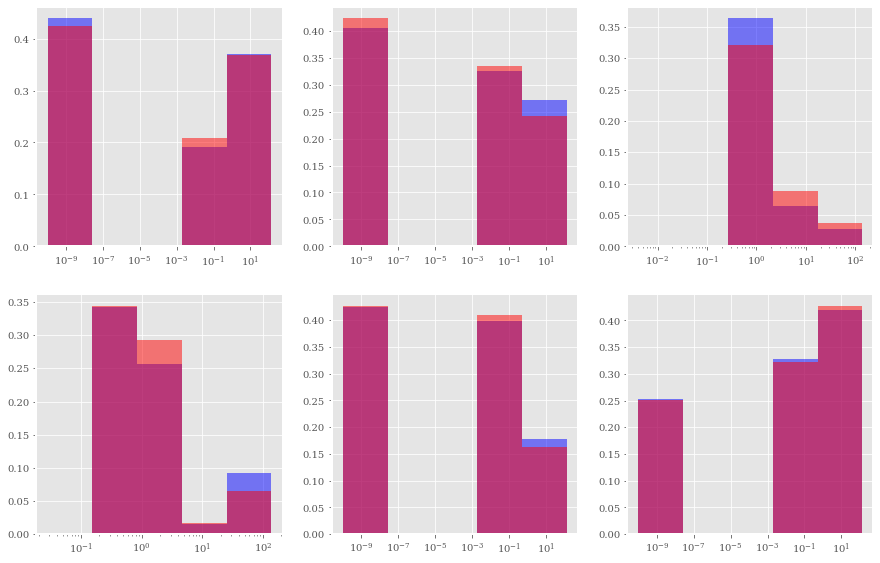

In [34]:
#tr_values is the training data used for the shadow classifier
#te_values is the testing data used for the shadow classifier

#tr_labels is the y of the training data used for the shadow classifier
#te_labes is the y of the testing data used for the shadow classifier

#data values values from the target classifier
#data labels labels from the target classifier

risk_score = calculate_risk_score(MIA.s_tr_m_entr, MIA.s_te_m_entr, MIA.s_tr_labels, MIA.s_te_labels, MIA.t_tr_m_entr, MIA.t_tr_labels, log_bins=True)

In [35]:
MIA = black_box_benchmarks(miss_shadow_train_performance,miss_shadow_test_performance,miss_target_train_performance,miss_target_test_performance,num_classes=n_features)

print("MIA evaluation with shadow != model MISSclassification")

MIA._mem_inf_benchmarks()

MIA = black_box_benchmarks(miss_shadow_train_performance,miss_shadow_test_performance,class_target_train_performance,class_target_test_performance,num_classes=n_features)

print("\nMIA evaluation with shadow != model correct classification")

MIA._mem_inf_benchmarks()

MIA evaluation with shadow != model MISSclassification
For membership inference attack via correctness, the attack acc is 0.500, with train acc 0.000 and test acc 0.000
For membership inference attack via confidence, the attack acc is 0.520
For membership inference attack via entropy, the attack acc is 0.506
For membership inference attack via modified entropy, the attack acc is 0.521

MIA evaluation with shadow != model correct classification
For membership inference attack via correctness, the attack acc is 0.500, with train acc 1.000 and test acc 1.000
For membership inference attack via confidence, the attack acc is 0.504
For membership inference attack via entropy, the attack acc is 0.490
For membership inference attack via modified entropy, the attack acc is 0.504
